# Rainforest Connection Species Audio Detection

## (Automating the detection of bird and frog species in a tropical soundscape)

## EDA

In [1]:
import pandas as pd
import librosa as librosa
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import librosa.display
from PIL import Image, ImageFile
from fastai.vision.all import *
from pydub import AudioSegment
from pydub.utils import make_chunks
import shutil
import os
from os.path import exists

In [2]:
# Read in true and false positive df
tpdf = pd.read_csv('train_tp.csv')
fpdf = pd.read_csv('train_fp.csv')

In [3]:
tpdf.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70


In [4]:
tpdf.describe()

,species_id,songtype_id,t_min,f_min,t_max,f_max
count,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000
mean,12.023849,1.315789,29.388748,2907.110280,31.925867,6043.157895
std,7.101400,0.921055,17.488898,2528.642227,17.553856,3468.795425
min,0.000000,1.000000,0.026700,93.750000,0.666700,843.750000
25%,6.000000,1.000000,14.164000,947.461000,16.158150,3937.500000
50%,12.000000,1.000000,29.514650,2343.750000,31.869350,5062.500000
75%,18.000000,1.000000,45.257175,3843.750000,48.046800,8250.000000
max,23.000000,4.000000,59.253300,10687.500000,59.994700,13687.500000


In [5]:
# Check recordings with multiple species
dfman = tpdf
dfman['species_id'] = dfman['species_id'].astype('str')
df1 = (dfman.groupby('recording_id')['species_id']
       .apply(lambda x: ','.join(set(x.dropna())))
       .reset_index())
df1[df1['species_id'].str.len() > 2]

,recording_id,species_id
108,178b835e3,"16,20"
123,1aa00dc63,"12,23"
199,2bcddf9a5,"3,5"
208,2d09eb065,"15,19"
217,2eb098e76,"3,2"
239,34340b225,"5,23"
241,349095631,"0,9"
288,400b7210c,"17,19"
304,43d34d63c,"15,2"
374,551385b05,"11,23"


In [6]:
# Check temporal structure of a recording with multiple species
tpdf[tpdf['recording_id'] == 'ed2f84e75']

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
1146,ed2f84e75,23,4,24.7815,6459.96,32.7053,11627.9
1147,ed2f84e75,22,1,19.8880,10687.50,21.4933,13687.5
1148,ed2f84e75,5,1,19.6107,4781.25,21.9627,10406.2


## Test Spectrogram Creation from Audio

In [7]:
# Create path to audio files in df
tpdf['audio_path'] = 'train/' + tpdf['recording_id'] + '.flac'

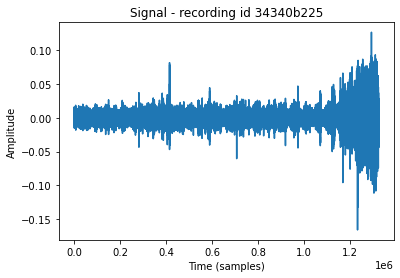

In [8]:
# Plot signal of a recording
idx = 256
y, sr = librosa.load(tpdf.iloc[idx]['audio_path'])
fig, ax = plt.subplots(1, 1)
ax.plot(y);
ax.set_title('Signal - recording id {}'.format(tpdf.iloc[idx]['recording_id']));
ax.set_xlabel('Time (samples)');
ax.set_ylabel('Amplitude');

/opt/conda/envs/fastai/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/opt/conda/envs/fastai/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/opt/conda/envs/fastai/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


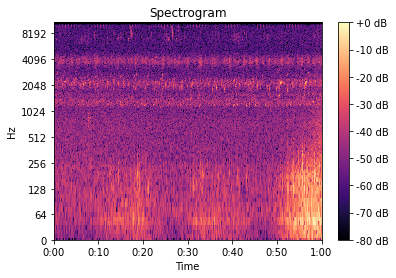

In [9]:
# Plot spectrogram of same signal
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log', ax=ax);
ax.set_title('Spectrogram');
fig.colorbar(img, ax=ax, format='%+2.0f dB');

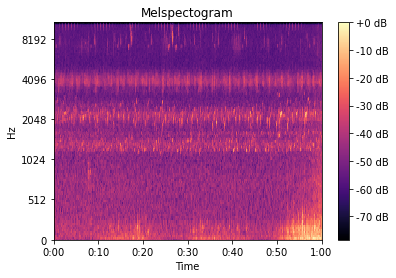

In [10]:
# Plot melspectrogram of same signal
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), y_axis='mel', x_axis='time')
ax.set_title('Melspectogram');
fig.colorbar(img, ax=ax, format='%+2.0f dB');

In [11]:
# Plot melspectrogram and save as png image
fig, ax = plt.subplots(1, 1, figsize=(0.72, 0.72))
y, sr = librosa.load(tpdf.iloc[idx]['audio_path'])
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
img = librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), y_axis='mel', x_axis='time')
ax.set_axis_off()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
fig.savefig('melspectogram_example.png', dpi=400)
plt.close(fig)
plt.close('all')
del y
del mel_spec

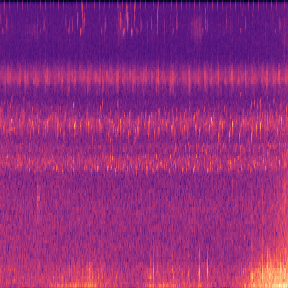

In [12]:
# Check saved melspectrogram
im = Image.open('melspectogram_example.png')
display(im)

## Manage Audio Recordings

### Slice TP Training Audio Clips Into 4 Second Chunks

In [13]:
# # Segment all TP audio clips into 4 second chunks, export to new folder
# for row in tpdf.itertuples():
#     file_name = row.recording_id
#     song = AudioSegment.from_file("train/{}.flac".format(file_name), "flac")
#     chunks = make_chunks(song, 4000) # Make chunks of 4 secs
    
#     # Export all individual chunks as flac
#     for i, chunk in enumerate(chunks):
#         chunk.export("train_chunks/{}_{}.flac".format(file_name, i), format="flac")

### Copy Chunks With Species Detected to Different Directory

In [14]:
# For each species in each recording, get chunk numbers that would contain recording of species
tpdf['stchunk'] = np.floor(tpdf['t_min']/4).astype(int)
tpdf['enchunk'] = np.floor(tpdf['t_max']/4).astype(int)

In [15]:
# # Export these relevant chunks to a final directory
# for row in tpdf.itertuples():
#     file_name = row.recording_id
#     for i in range(row.stchunk,row.enchunk+1):
#         shutil.copy("train_chunks/{}_{}.flac".format(file_name, i), "tp_final_train_chunks/")

### Slice FP Training Audio Clips Into 4 Second Chunks

In [16]:
# # Segment all FP audio clips into 4 second chunks, export to new folder
# for row in fpdf.itertuples():
#     file_name = row.recording_id
#     if exists("train_chunks/{}_0.flac".format(file_name)) == False:
#         song = AudioSegment.from_file("train/{}.flac".format(file_name), "flac")
#         chunks = make_chunks(song, 4000) # Make chunks of 4 secs
        
#         # Export all individual chunks as flac
#         for i, chunk in enumerate(chunks):
#             chunk.export("train_chunks/{}_{}.flac".format(file_name, i), format="flac")

### Copy Chunks With FP Species Detected to Different Directory

In [17]:
# For each species in each recording, get chunk numbers that would contain recording of species
fpdf['stchunk'] = np.floor(fpdf['t_min']/4).astype(int)
fpdf['enchunk'] = np.floor(fpdf['t_max']/4).astype(int)

In [18]:
# # Export these relevant chunks to a final directory
# for row in fpdf.itertuples():
#     file_name = row.recording_id
#     for i in range(row.stchunk,row.enchunk+1):
#         shutil.copy("train_chunks/{}_{}.flac".format(file_name, i), "fp_final_train_chunks/")

## Create Melspectrograms from Audio Chunks

### Create Melspectrograms for TPs

In [19]:
# # For all files in final chunk directory, create and save melspectrogram with same name as recording
# directory = "tp_final_train_chunks/"
# for filename in os.listdir(directory):
#     fig, ax = plt.subplots(1, 1, figsize=(0.72, 0.72))
#     y, sr = librosa.load(os.path.join(directory, filename))
#     mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
#     img = librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), y_axis='mel', x_axis='time')
#     ax.set_axis_off()
#     fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
#     fig.savefig("{}/{}.png".format(directory, filename[:-5]), dpi=400)
#     plt.close(fig)
#     plt.close('all')
#     del y
#     del mel_spec

### Create Melspectrograms for FPs

In [20]:
# # For all files in final chunk directory, create and save melspectrogram with same name as recording
# directory = "fp_final_train_chunks/"
# for filename in os.listdir(directory):
#     fig, ax = plt.subplots(1, 1, figsize=(0.72, 0.72))
#     y, sr = librosa.load(os.path.join(directory, filename))
#     mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
#     img = librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), y_axis='mel', x_axis='time')
#     ax.set_axis_off()
#     fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
#     fig.savefig("{}/{}.png".format(directory, filename[:-5]), dpi=400)
#     plt.close(fig)
#     plt.close('all')
#     del y
#     del mel_spec

## Create One-Hot Encoding for Each Chunk

### Create One-Hot Encoded Vectors for TP Chunks

In [21]:
# Create list for species present in individual chunks
tp_list = []
for row in tpdf.itertuples():
    file_name = row.recording_id
    species = row.species_id
    for i in range(row.stchunk,row.enchunk+1):
        tp_list.append([file_name, i, species])

# Create df from list
tp_minimized = pd.DataFrame(tp_list, columns=['recording_id', 'chunk_id', 'species_id'])

In [22]:
# Get one hot encoding of species column
tp_one_hot = pd.get_dummies(tp_minimized['species_id'].astype(int))

# Create full recording name
tp_minimized['recording_id'] = tp_minimized['recording_id'] + '_' + tp_minimized['chunk_id'].astype(str)

# Drop chunk and species columns as they are now irrelevant
tp_minimized = tp_minimized.drop('chunk_id',axis = 1)
tp_minimized = tp_minimized.drop('species_id',axis = 1)

# Join the encoded df
tp_one_hot = tp_minimized.join(tp_one_hot)

# Convert cols to str
tp_one_hot.columns = tp_one_hot.columns.map(lambda x : 's' + str(x) if x !='recording_id' else x)

# Group recording ids
tp_one_hot = tp_one_hot.groupby('recording_id', as_index=False).max()

In [23]:
tp_one_hot.head()

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,003bec244_11,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,006ab765f_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,006ab765f_11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,006ab765f_9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,007f87ba2_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
tp_one_hot.describe()

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
count,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,...,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000
mean,0.032359,0.030793,0.025052,0.030271,0.038622,0.040710,0.038100,0.045929,0.053236,0.031315,...,0.029749,0.047495,0.037578,0.073591,0.031837,0.028184,0.041232,0.034969,0.029749,0.138309
std,0.176998,0.172802,0.156324,0.171378,0.192743,0.197669,0.191488,0.209386,0.224562,0.174214,...,0.169940,0.212750,0.190224,0.261172,0.175612,0.165541,0.198878,0.183748,0.169940,0.345314
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Create One-Hot Encoded Vectors for FP Chunks

In [25]:
# Create list for species present in individual chunks
fp_list = []
for row in fpdf.itertuples():
    file_name = row.recording_id
    species = row.species_id
    for i in range(row.stchunk,row.enchunk+1):
        fp_list.append([file_name, i, species])

# Create df from list
fp_minimized = pd.DataFrame(fp_list, columns=['recording_id', 'chunk_id', 'species_id'])

In [26]:
# Get one hot encoding of species column
fp_one_hot = pd.get_dummies(fp_minimized['species_id'].astype(int))

# Create full recording name
fp_minimized['recording_id'] = fp_minimized['recording_id'] + '_' + fp_minimized['chunk_id'].astype(str)

# Drop chunk and species columns as they are now irrelevant
fp_minimized = fp_minimized.drop('chunk_id',axis = 1)
fp_minimized = fp_minimized.drop('species_id',axis = 1)

# Join the encoded df
fp_one_hot = fp_minimized.join(fp_one_hot)

# Convert all 1s to 0s since these are false positives, there are no targets
num = fp_one_hot._get_numeric_data()
num[num > 0] = 0

# Convert cols to str
fp_one_hot.columns = fp_one_hot.columns.map(lambda x : 's' + str(x) if x !='recording_id' else x)

# Group recording ids
fp_one_hot = fp_one_hot.groupby('recording_id', as_index=False).max()

In [27]:
fp_one_hot.head()

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,00204008d_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,00204008d_4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,00204008d_6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00204008d_7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,003b04435_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
fp_one_hot.describe()

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
count,11302.0,11302.0,11302.0,11302.0,11302.0,11302.0,11302.0,11302.0,11302.0,11302.0,...,11302.0,11302.0,11302.0,11302.0,11302.0,11302.0,11302.0,11302.0,11302.0,11302.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## CV Model Training

### ResNet34 With TPs

In [29]:
# Create list of classes
voc = list(tp_one_hot.columns[1:])

In [30]:
rfcx = DataBlock(blocks=(ImageBlock, MultiCategoryBlock(encoded=True, vocab=voc)),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42), # Random 20% validation set
                   get_x=ColReader('recording_id', pref="tp_final_train_chunks/", suff='.png'),
                   get_y=ColReader(voc))

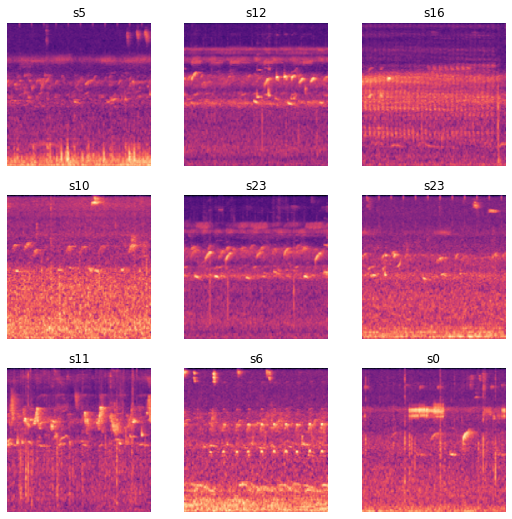

In [31]:
dls = rfcx.dataloaders(tp_one_hot)
dls.show_batch()

In [32]:
learn = cnn_learner(dls, resnet34, metrics=F1ScoreMulti())

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.033113110810518265)

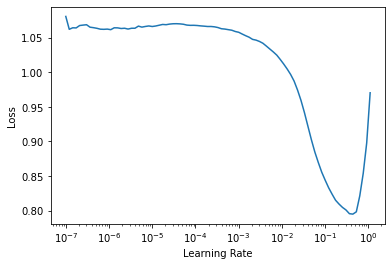

In [33]:
learn.lr_find()

In [34]:
learn.fit_one_cycle(4, 3e-2)

epoch,train_loss,valid_loss,f1_score,time
0,0.663164,0.246802,0.005710,00:10
1,0.375369,0.197540,0.052085,00:09
2,0.254486,0.113255,0.367178,00:09
3,0.186547,0.102293,0.427232,00:09


In [35]:
learn.unfreeze()

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=0.00015848931798245758)

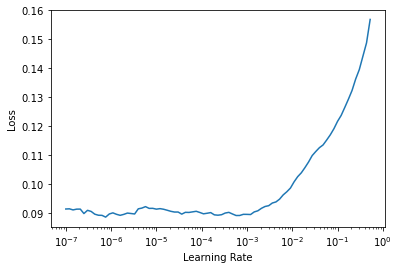

In [36]:
learn.lr_find()

In [37]:
learn.fit_one_cycle(6, lr_max=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,f1_score,time
0,0.091244,0.101801,0.405445,00:12
1,0.085366,0.093870,0.461810,00:12
2,0.077314,0.091427,0.475201,00:12
3,0.069295,0.087584,0.491113,00:12
4,0.062332,0.087051,0.509705,00:12
5,0.057629,0.086884,0.512136,00:12


### ResNet34 With TPs and FPs

In [38]:
# # Combine all TPs and FPs, copy all TP and FP images to new dir
# for row in tp_one_hot.itertuples():
#     shutil.copy("tp_final_train_chunks/{}.png".format(row.recording_id), "tpfp_final/")
    
# for row in fp_one_hot.itertuples():
#     shutil.copy("fp_final_train_chunks/{}.png".format(row.recording_id), "tpfp_final/")

In [39]:
# Create new df for tp and fp
tpfp_one_hot = pd.concat([tp_one_hot, fp_one_hot.sample(frac=0.05, random_state=42)], ignore_index=True)

In [40]:
rfcx = DataBlock(blocks=(ImageBlock, MultiCategoryBlock(encoded=True, vocab=voc)),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42), # Random 20% validation set
                   get_x=ColReader('recording_id', pref="tpfp_final/", suff='.png'),
                   get_y=ColReader(voc))

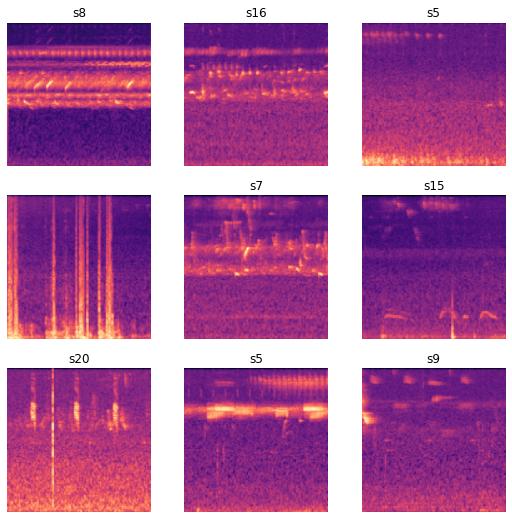

In [41]:
dls = rfcx.dataloaders(tpfp_one_hot)
dls.show_batch()

In [42]:
learn = cnn_learner(dls, resnet34, metrics=F1ScoreMulti())

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.033113110810518265)

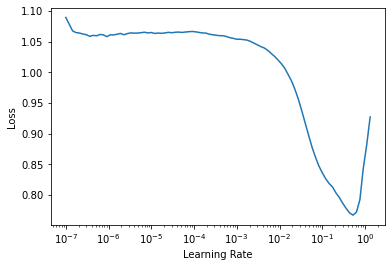

In [43]:
learn.lr_find()

In [44]:
learn.fit_one_cycle(3, 3e-2)

epoch,train_loss,valid_loss,f1_score,time
0,0.502961,0.198298,0.039305,00:13
1,0.273907,0.124691,0.059435,00:12
2,0.182249,0.101908,0.185594,00:12


In [45]:
learn.unfreeze()

SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=1.3182567499825382e-06)

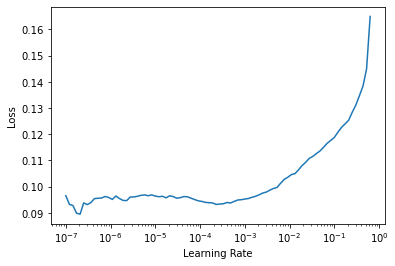

In [46]:
learn.lr_find()

In [47]:
learn.fit_one_cycle(6, lr_max=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,f1_score,time
0,0.097806,0.100991,0.182685,00:16
1,0.094741,0.099001,0.197993,00:16
2,0.093253,0.098002,0.201767,00:16
3,0.092401,0.097243,0.208812,00:16
4,0.090935,0.096706,0.215659,00:16
5,0.089057,0.097082,0.196708,00:16


### ResNet34 With TPs, Adding Mix-Up

In [48]:
rfcx = DataBlock(blocks=(ImageBlock, MultiCategoryBlock(encoded=True, vocab=voc)),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42), # Random 20% validation set
                   get_x=ColReader('recording_id', pref="tp_final_train_chunks/", suff='.png'),
                   get_y=ColReader(voc))

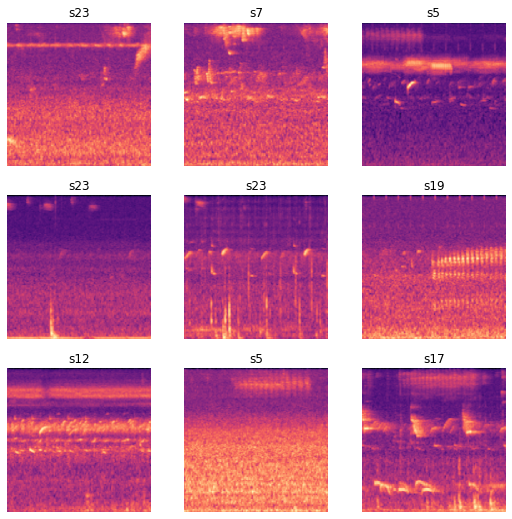

In [49]:
dls = rfcx.dataloaders(tp_one_hot)
dls.show_batch()

In [50]:
# Add mixup to learner
learn = cnn_learner(dls, resnet34, metrics=F1ScoreMulti(), cbs=MixUp())

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.033113110810518265)

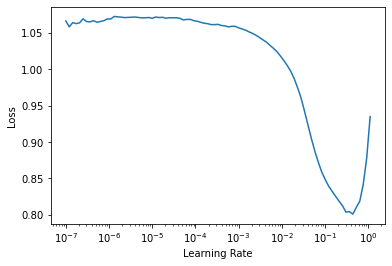

In [51]:
learn.lr_find()

In [52]:
learn.fit_one_cycle(3, 3e-2)

epoch,train_loss,valid_loss,f1_score,time
0,0.607072,0.250923,0.019178,00:10
1,0.364980,0.155701,0.105444,00:09
2,0.265980,0.127385,0.204734,00:10


In [53]:
learn.unfreeze()

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=8.31763736641733e-06)

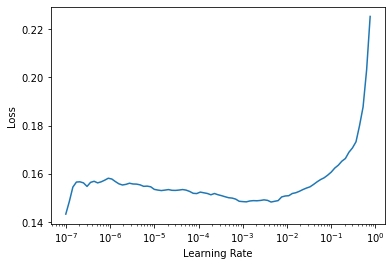

In [54]:
learn.lr_find()

In [55]:
# Train for more epochs
learn.fit_one_cycle(20, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,f1_score,time
0,0.154408,0.127063,0.199221,00:12
1,0.154322,0.125166,0.199945,00:12
2,0.152413,0.122713,0.214377,00:12
3,0.148571,0.119508,0.209057,00:12
4,0.146178,0.115523,0.220964,00:12
5,0.142832,0.112108,0.256157,00:12
6,0.139875,0.110561,0.274788,00:12
7,0.136763,0.107813,0.300888,00:12
8,0.133078,0.106003,0.330622,00:12
9,0.129999,0.103298,0.340966,00:12


### ResNet50 With TPs

In [56]:
rfcx = DataBlock(blocks=(ImageBlock, MultiCategoryBlock(encoded=True, vocab=voc)),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42), # Random 20% validation set
                   get_x=ColReader('recording_id', pref="tp_final_train_chunks/", suff='.png'),
                   get_y=ColReader(voc))

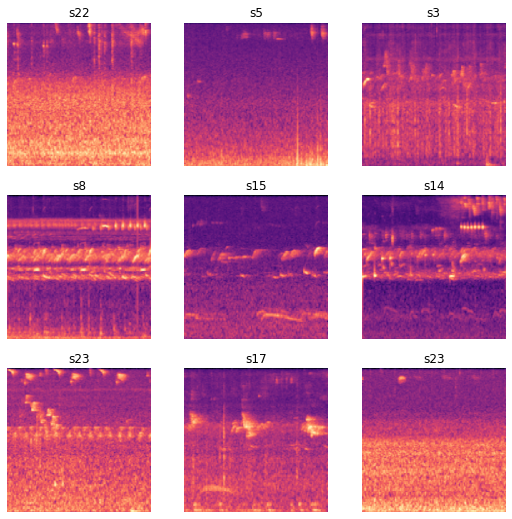

In [57]:
dls = rfcx.dataloaders(tp_one_hot)
dls.show_batch()

In [58]:
# Use resnet50
learn = cnn_learner(dls, resnet50, metrics=F1ScoreMulti())

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.03981071710586548)

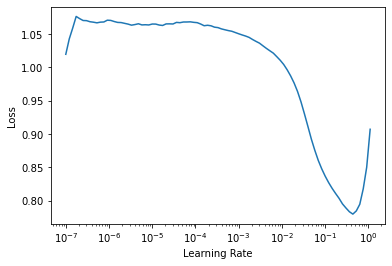

In [59]:
learn.lr_find()

In [60]:
learn.fit_one_cycle(3, 3e-2)

epoch,train_loss,valid_loss,f1_score,time
0,0.589994,0.329124,0.008167,00:22
1,0.344462,0.161037,0.119677,00:20
2,0.240941,0.123076,0.195044,00:20


In [61]:
learn.unfreeze()

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=6.309573450380412e-07)

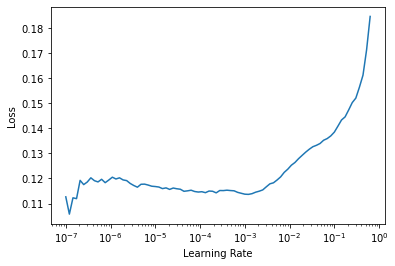

In [62]:
learn.lr_find()

In [63]:
learn.fit_one_cycle(6, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,f1_score,time
0,0.121276,0.119448,0.193752,00:27
1,0.116152,0.115839,0.226743,00:27
2,0.109399,0.110397,0.284509,00:27
3,0.102350,0.107801,0.284700,00:27
4,0.096986,0.106733,0.296732,00:27
5,0.093457,0.106676,0.298320,00:27


## Select Best Model, Train Using Full Data

In [64]:
rfcx = DataBlock(blocks=(ImageBlock, MultiCategoryBlock(encoded=True, vocab=voc)),
                   splitter=RandomSplitter(valid_pct=0., seed=42), # Including all data, no validation set
                   get_x=ColReader('recording_id', pref="tp_final_train_chunks/", suff='.png'),
                   get_y=ColReader(voc))

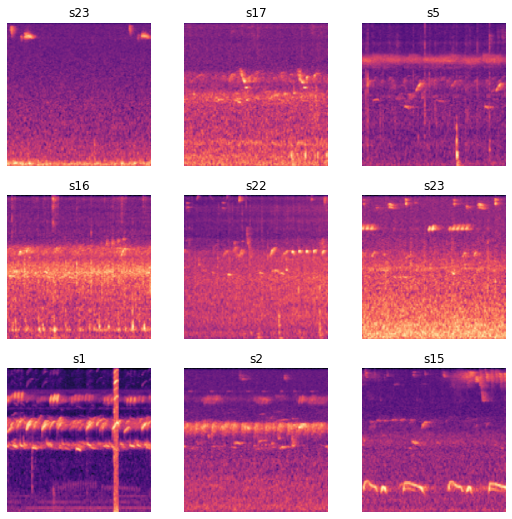

In [65]:
dls = rfcx.dataloaders(tp_one_hot)
dls.show_batch()

In [66]:
learn = cnn_learner(dls, resnet34, metrics=F1ScoreMulti())

In [67]:
learn.fit_one_cycle(3, 3e-2)
learn.unfreeze()
learn.fit_one_cycle(8, lr_max=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,f1_score,time
0,0.538503,None,None,00:10
1,0.302291,None,None,00:10
2,0.202109,None,None,00:10


/opt/conda/envs/fastai/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,f1_score,time
0,0.103359,None,None,00:14
1,0.102232,None,None,00:14
2,0.100259,None,None,00:14
3,0.097553,None,None,00:14
4,0.095599,None,None,00:14
5,0.093556,None,None,00:13
6,0.091743,None,None,00:14
7,0.089962,None,None,00:14


In [68]:
# Export learner
learn.export('models/rfcx_tp_rn34.pkl')

## Prepare Test Audio Chunks, Create Dataframe for Chunks

In [69]:
# Read in submission csv
sample_submission = pd.read_csv('sample_submission.csv')

In [70]:
# # Segment all test audio clips into 4 second chunks, export to new folder
# for row in sample_submission.itertuples():
#     file_name = row.recording_id
#     song = AudioSegment.from_file("test/{}.flac".format(file_name), "flac")
#     chunks = make_chunks(song, 4000) # Make chunks of 4 secs
    
#     # Export all individual chunks as flac
#     for i, chunk in enumerate(chunks):
#         chunk.export("test_chunks/{}_{}.flac".format(file_name, i), format="flac")

In [71]:
# # For all files in test chunk directory, create and save melspectrogram with same name as recording
# directory = "test_chunks/"
# for filename in os.listdir(directory):
#     fig, ax = plt.subplots(1, 1, figsize=(0.72, 0.72))
#     y, sr = librosa.load(os.path.join(directory, filename))
#     mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
#     img = librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), y_axis='mel', x_axis='time')
#     ax.set_axis_off()
#     fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
#     fig.savefig("{}/{}.png".format(directory, filename[:-5]), dpi=400)
#     plt.close(fig)
#     plt.close('all')
#     del y
#     del mel_spec

In [72]:
# Generate list of all test chunk spectrograms
sample_list = [os.path.basename(f)[:-4] for f in glob.glob("test_chunks/*.png")]

# Create df from list
sample_minimized = pd.DataFrame(sample_list, columns=['recording_id'])

## Get Predictions on Test Data

In [73]:
# Get list of test chunk image paths
test_files = ['test_chunks/'f'{i}.png' for i in sample_minimized.recording_id]

In [74]:
# Allow truncated images to be loaded
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [75]:
# Get predictions on all test chunks
test_dl = dls.test_dl(test_files)
test_preds,_ = learn.get_preds(dl=test_dl)

## Create Submission File

In [76]:
# Concatenate recording/chunk id with learner predictions
submission = pd.concat([sample_minimized['recording_id'], pd.DataFrame(test_preds.numpy(), columns=sample_submission.columns[1:])], axis=1)

In [77]:
# Delete chunk id, group by recording id and sum predictions
submission['recording_id'] = submission['recording_id'].str.replace('_\d+$', '')
submission = submission.groupby(['recording_id'], as_index=False).sum()

In [78]:
submission.head()

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,0.294029,0.347775,0.235065,1.855292,0.125448,0.274664,0.126684,0.307837,0.096327,...,0.354829,0.816381,0.072259,0.145148,0.982822,0.068432,0.177043,0.084096,0.547377,1.933583
1,003bc2cb2,0.027542,0.073469,0.337985,0.223035,0.204304,0.037815,0.228196,0.157288,0.133055,...,0.045820,0.099551,7.949362,0.362117,0.040706,0.238147,0.082852,0.106096,0.389282,0.258735
2,0061c037e,0.207789,0.026412,0.010174,0.125780,0.028663,1.751178,0.213646,0.729466,0.016057,...,0.003292,0.227422,0.032698,0.137119,0.039018,0.137049,0.438868,0.007972,1.138481,3.624047
3,010eb14d3,3.802069,1.092017,0.036003,0.039045,0.004102,0.111307,0.006672,0.003066,6.818711,...,0.040971,0.043960,0.005495,0.015473,0.187865,0.671572,0.011915,0.216936,0.035981,0.102023
4,011318064,0.008203,0.125979,0.038945,0.480638,0.236791,0.036345,0.321962,0.068921,0.016969,...,1.113955,1.824124,0.048159,0.896191,0.069915,0.010549,0.513366,0.071691,0.822327,0.147483


In [ ]:
# Normalize cols
for cols in submission.columns[1:]:
    submission[cols] = (submission[cols]-submission[cols].min()) / (submission[cols].max()-submission[cols].min())

In [79]:
# Export submission file
submission.to_csv('submission/submission_tp_rn34.csv', index=False)